In [356]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

home_path = r'C:\\Users\joche\FIM Kernkompetenzzentrum\Projekt VIdES - Dokumente\General\07_Arbeitsordner\04_Ergebnisse\20220920_Ergebnisse_4_Wochen'
out_path = r'C:\Users\joche\FIM Kernkompetenzzentrum\Projekt VIdES - Dokumente\General\07_Arbeitsordner\04_Ergebnisse\20220920_Ergebnisse_4_Wochen\results\Abbildungen\house_inspection'
all_ucs = [i.name for i in os.scandir(home_path) if i.is_dir() if 'case' in i.name.lower()]
os.chdir(home_path)

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [353]:
# function for filtering filepaths and -names for use case and search terms (mm, member, etc.)
def get_filepaths(home_path, uc_path, incl=None, excl=None):
    incl = [incl] if type(incl) is str else incl
    excl = [excl] if type(excl) is str else excl
    fpaths, fnames = [], []
    for root, dir, file in os.walk(top=home_path + f'/{uc_path}', topdown=True):
        if incl is None and excl is None:
            fpaths += [os.path.join(root,f) for f in file]
            fnames += [f for f in file]
        elif incl is not None and excl is None:
            fpaths += [os.path.join(root,f) for f in file if all(x in f for x in incl)]
            fnames += [f for f in file if all(x in f for x in incl)]
        elif incl is None and excl is not None:
            fpaths += [os.path.join(root,f) for f in file if not any(y in f for y in excl)]
            fnames += [f for f in file if not any(y in f for y in excl)]
        else:
            fpaths += [os.path.join(root,f) for f in file if all(x in f for x in incl) if not any(y in f for y in excl)]
            fnames += [f for f in file if all(x in f for x in incl) if not any(y in f for y in excl)]
            
    fnames = pd.Series([i.split('\\id')[0].split('germany\\')[-1].split('\\')[-1] for i in fpaths]).unique()
    
    return fpaths, fnames

# function to return name of house from i_nr
def get_battery_house_name(home_path, i_nr = 0):
    uc_path = all_ucs = [i.name for i in os.scandir(home_path) if i.is_dir() if 'case' in i.name.lower()][0]
    fpaths, fnames = get_filepaths(home_path, uc_path, incl=['.csv', 'battery'])
    
    return fnames[i_nr]
    
# function for obtaining trading- and battery information df for selected use case and house number
def get_battery_house_info_for_uc(home_path, uc_path, i_nr = 0):
    nr_months = 4
    # get all paths for .csv files with battery for use case 1
    fpaths_battery, fnames_battery = get_filepaths(home_path, uc_path, incl=['.csv', 'battery'])
    fpaths_battery = [i.replace('\\\\', '\\') if '\\\\' in i else i for i in fpaths_battery]
    # from all entities, select one entity i
    i_s = [i for i in range(int(len(fpaths_battery)/nr_months))]
    assert i_nr < len(i_s), f'can only select one of {len(i_s)-1} houses. Please lower i_nr.'
    i = i_s[i_nr]
    # obtain i's name
    iname = fpaths_battery[i].split('germany\\')[-1].split('\\id')[0].split('\\')[-1]
    # get trades.csv for i
    fpaths_i, fnames_i = get_filepaths(home_path, uc_path, incl=f'{iname}.csv', excl=['mm', 'member'])
    # for i, combine all monthly filepaths to one df
    dfs = []
    for fp_battery, fp_i in zip(fpaths_battery[i::int(len(fpaths_battery)/nr_months)], fpaths_i):
        temp_battery, temp_i = pd.read_csv(fp_battery), pd.read_csv(fp_i)
        temp_battery.slot, temp_i.slot = pd.to_datetime(temp_battery.slot).dt.tz_localize(None), pd.to_datetime(temp_i.slot).dt.tz_localize(None)
        temp_out = temp_battery.merge(temp_i, on='slot')
        dfs.append(temp_out)
    df = pd.concat(dfs, axis=0)
    df.set_index(df.slot, inplace=True)
    df.drop('slot', axis=1, inplace=True)
    
    return df, iname

# function to plot time series information (trading price and -volume, battery level) for house i and selected use case
def plot_battery_house_info_for_uc(df, uc_path):
    fig, ax = plt.subplots(figsize = (10,5), nrows=3, sharex = True)
    fig.suptitle(f'{name}, {uc_path}')
    l1 = df.reset_index()['avg trade rate [ct./kWh]'].plot(ax=ax[0], legend=True, ylabel='ct./kWh', color = (184/235,50/235,138/235))
    l2 = df.reset_index()['total energy traded [kWh]'].plot(ax=ax[1], legend=True, ylabel='kWh', color = (184/235,50/235,138/235))
    l3 = df.reset_index()[['charge [kWh]']].plot(ax=ax[2], legend=True, ylabel='kWh', color = (184/235,50/235,138/235))

    fig.canvas.draw()
    labels = [int(re.sub(u"\u2212", "-", i.get_text())) for i in ax[2].get_xticklabels()]
    new_labels = ['' if int(i) not in df.reset_index().index else df.reset_index().loc[df.reset_index().index == int(i),'slot'].values[0] for i in labels]
    new_labels = ['' if not i else str(i).split('T')[0] for i in new_labels]
    ax[2].set_xticklabels(new_labels)
    plt.tight_layout()

    return fig

# function to return mean and standard deviation of measure (column in df) for selected use case (uc_path) and house (i_nr)
def calculate_battery_house_measure_mean_and_std(home_path, uc_path, i_nr, measure = 'charge [%]'):
    # obtain df for house i and uc
    df, name = get_battery_house_info_for_uc(home_path, uc_path, i_nr)
    assert measure in df.columns, f'measure is not in the columns {df.columns}'
    
    return df[measure].mean(axis=0), df[measure].std(axis=0)

def get_battery_house_measure_mean_and_std_all_ucs(home_path, i_nr, measure):
    # verify that measure exists
    df, name = get_battery_house_info_for_uc(home_path, uc_path='Base_Case', i_nr=i_nr)
    assert measure in df.columns, f'{measure} is not in df columns: {df.columns}'
    # create lists for use cases, measure means, and measure stds
    uc_names, means, stds = [], [], []
    all_ucs = [i.name for i in os.scandir(home_path) if i.is_dir() if 'case' in i.name.lower()]
    for uc in all_ucs:
        uc_names.append(uc)
        df, name = get_battery_house_info_for_uc(home_path, uc, i_nr)
        m, s = calculate_battery_house_measure_mean_and_std(home_path, uc, i_nr, measure=measure)
        means.append(m)
        stds.append(s)
    
    return name, uc_names, means, stds

In [364]:
# get overview over all possible measures
df, name = get_battery_house_info_for_uc(home_path, uc_path='use_case_1', i_nr=i_nr)
for c in df.columns:
    print(f'- {c}')

- energy traded [kWh]
- bought [kWh]
- sold [kWh]
- charge [kWh]
- offered [kWh]
- charge [%]
- avg trade rate [ct./kWh]
- min trade rate [ct./kWh]
- max trade rate [ct./kWh]
- # trades
- total energy traded [kWh]
- total trade volume [EURO ct.]


C:\Users\joche\AppData\Local\Temp\ipykernel_24432\4173243829.py:70: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[2].set_xticklabels(new_labels)
C:\Users\joche\AppData\Local\Temp\ipykernel_24432\4173243829.py:70: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[2].set_xticklabels(new_labels)
C:\Users\joche\AppData\Local\Temp\ipykernel_24432\4173243829.py:70: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[2].set_xticklabels(new_labels)
C:\Users\joche\AppData\Local\Temp\ipykernel_24432\4173243829.py:70: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[2].set_xticklabels(new_labels)
C:\Users\joche\AppData\Local\Temp\ipykernel_24432\4173243829.py:70: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[2].set_xticklabels(new_labels)
C:\Users\joche\AppData\Local\Temp\ipykernel_24432\4173243829.py:70: UserWarning: FixedFormatter should on

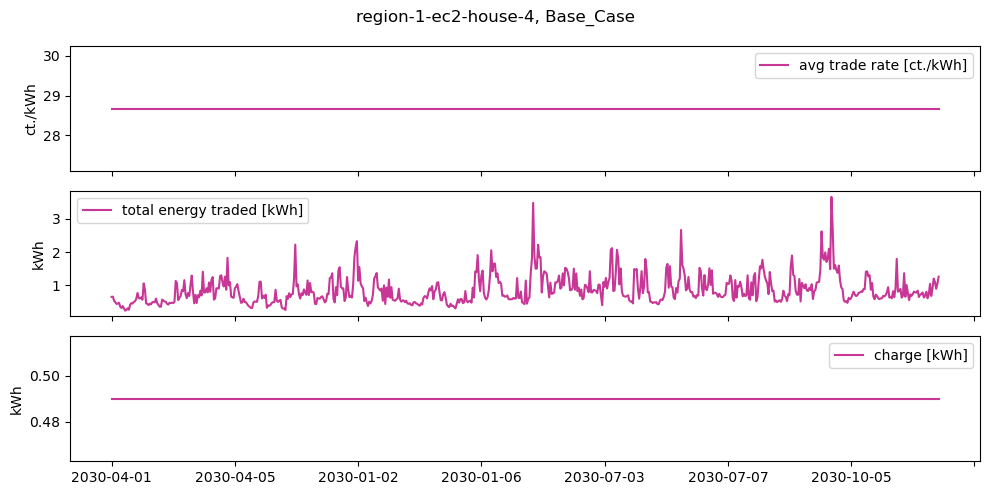

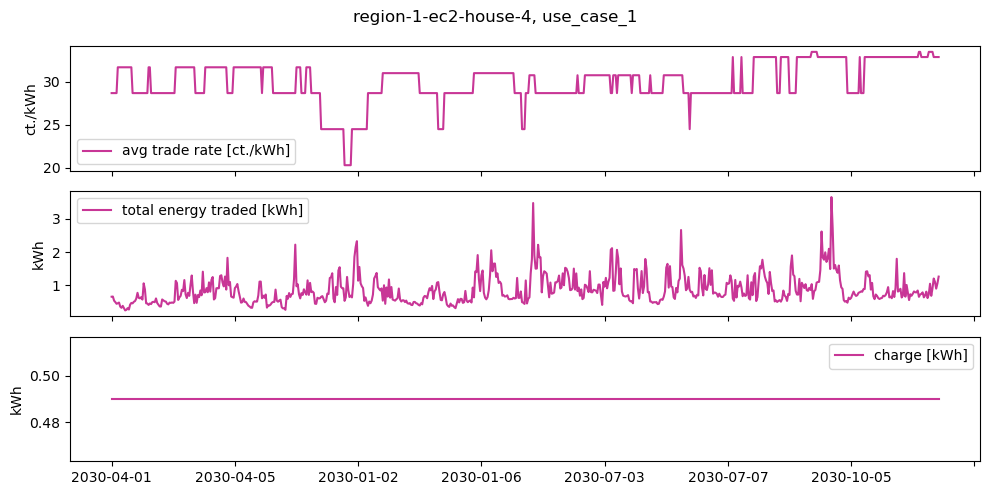

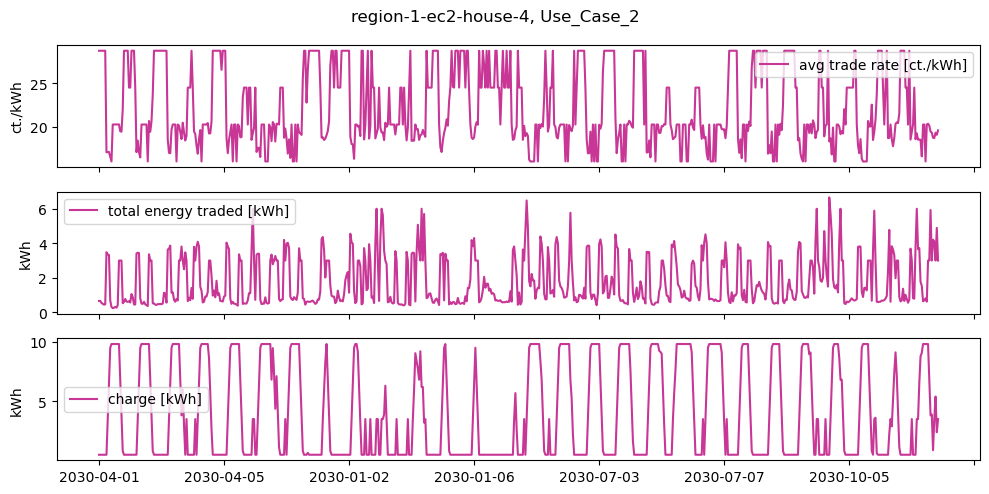

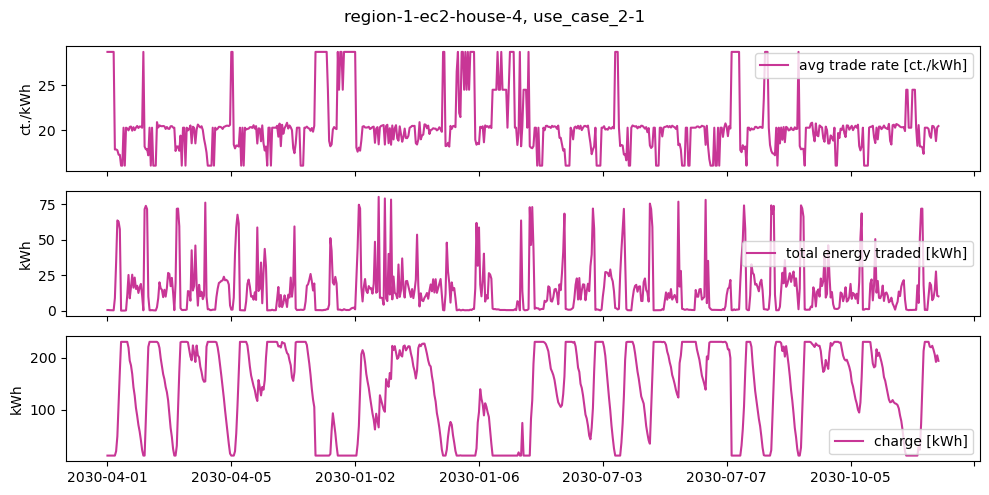

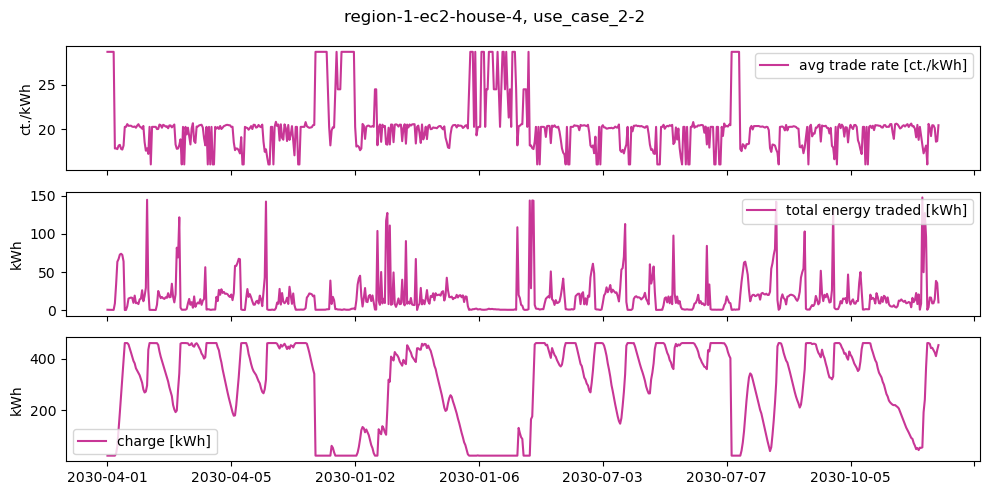

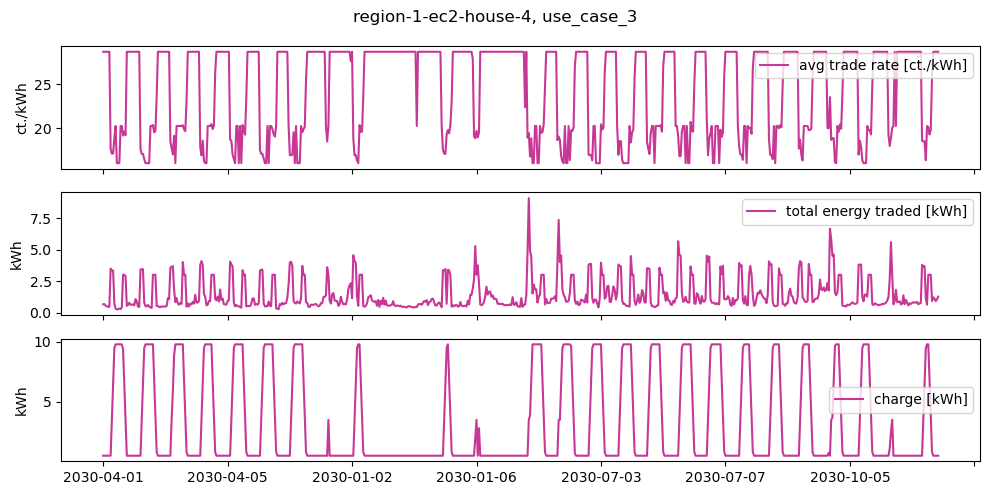

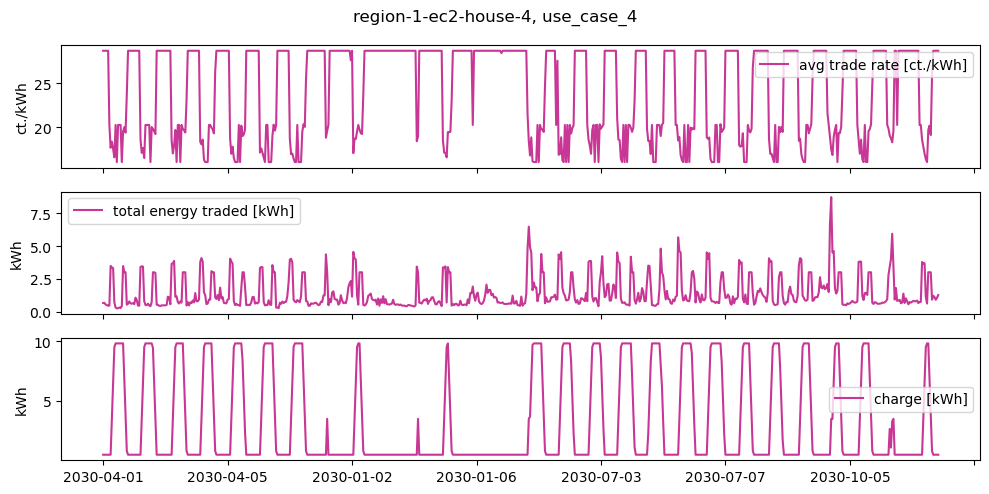

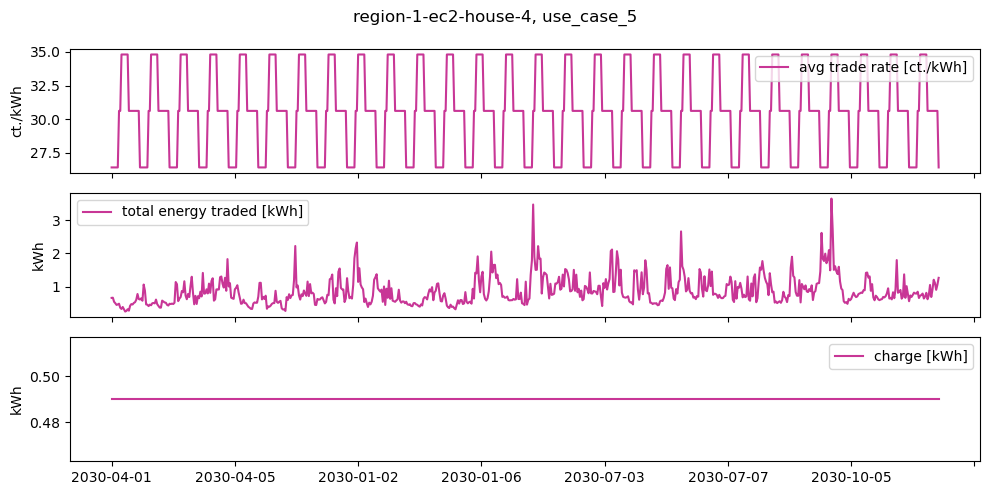

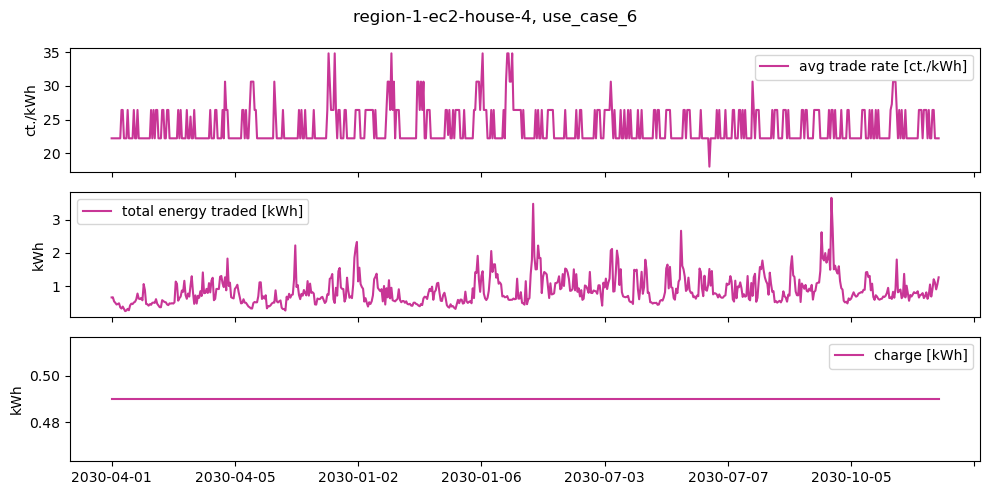

In [362]:
i_nr = 0
for uc_path in all_ucs:
    # obtain data and name for selected house and use case
    df, name = get_battery_house_info_for_uc(home_path, uc_path, i_nr)
    # plot data
    fig = plot_battery_house_info_for_uc(df, uc_path)
    fig.savefig(out_path + f'/2022 12 19 {name}_{uc_path}.png')

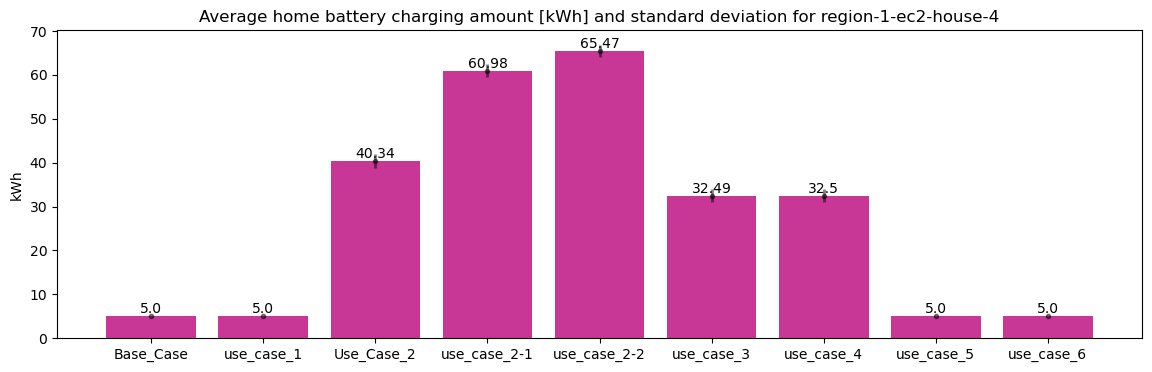

In [346]:
i_nr = 0
# obtain average charging level across all use cases for selected house
name, uc_names, means, stds = get_battery_house_measure_mean_and_std_all_ucs(home_path, i_nr, measure='charge [%]')

# plot
df, name = get_battery_house_info_for_uc(home_path, uc_path = 'Base_Case', i_nr=i_nr)
n = len(df)
fig, ax = plt.subplots(figsize = (14,4))
p1 = ax.bar(uc_names, means, color = (184/235,50/235,138/235))
ax.set_title(f'Average home battery charging amount [kWh] and standard deviation for {name}')
ax.set_ylabel('kWh')
# From std. to SE
yerr = [i/np.sqrt(n) for i in stds]
ax.errorbar(uc_names, means, yerr, fmt='.', color='black', elinewidth=2, capthick=10, errorevery=1, alpha=.5)
# bar labels
ax.bar_label(p1, labels=[round(i,2) for i in means], label_type='edge')
plt.show()

In [359]:
uc_path

'use_case_6'

In [361]:
fig.savefig(out_path + f'/2022 12 19 {name}_{uc_path}.png')

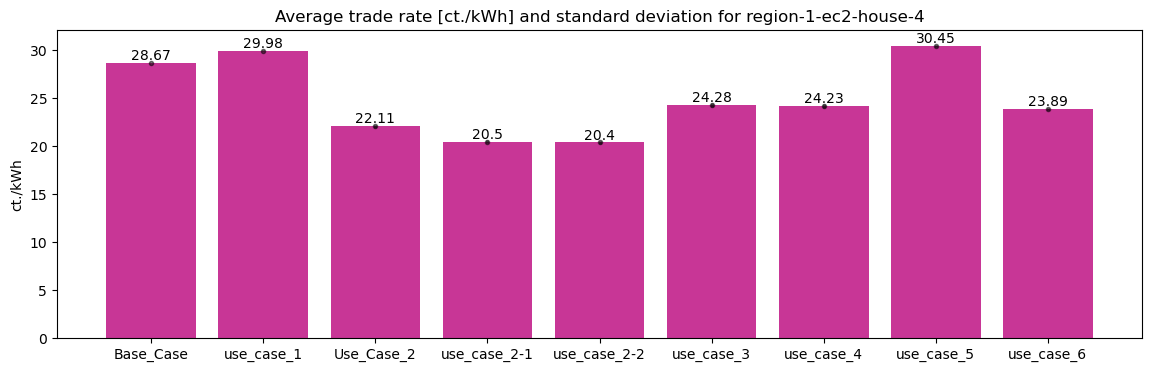

In [347]:
i_nr = 0
# obtain average charging level across all use cases for selected house
name, uc_names, means, stds = get_battery_house_measure_mean_and_std_all_ucs(home_path, i_nr, measure='avg trade rate [ct./kWh]')

# plot
df, name = get_battery_house_info_for_uc(home_path, uc_path = 'Base_Case', i_nr=i_nr)
n = len(df)
fig, ax = plt.subplots(figsize = (14,4))
p1 = ax.bar(uc_names, means, color = (184/235,50/235,138/235))
ax.set_title(f'Average trade rate [ct./kWh] and standard deviation for {name}')
ax.set_ylabel('ct./kWh')
# From std. to SE
yerr = [i/np.sqrt(n) for i in stds]
ax.errorbar(uc_names, means, yerr, fmt='.', color='black', elinewidth=2, capthick=10, errorevery=1, alpha=.5)
# bar labels
ax.bar_label(p1, labels=[round(i,2) for i in means], label_type='edge')
plt.show()